In [79]:
%pip install torchaudio librosa transformers datasets torch torchvision grad-cam torchaudio


Note: you may need to restart the kernel to use updated packages.


### Preprocessing Dataset

In [12]:
import os
import torch
import librosa
import numpy as np
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tv_transforms

# Define constants
SAMPLE_RATE = 16000  # Ensure consistency
N_MELS = 1287
FIXED_LENGTH = 256  # Fixed spectrogram length

class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]

        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            if len(y) == 0:
                print(f"Skipping empty file: {file_path}")
                return None

            # Convert to Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Resize spectrogram to fixed shape
            if mel_spectrogram.shape[1] < FIXED_LENGTH:
                pad_width = FIXED_LENGTH - mel_spectrogram.shape[1]
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spectrogram.shape[1] > FIXED_LENGTH:
                mel_spectrogram = mel_spectrogram[:, :FIXED_LENGTH]

            # Convert to PyTorch tensor
            mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
            mel_spectrogram = mel_spectrogram.unsqueeze(0)  # Add channel dimension

            return mel_spectrogram, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/training")
val_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/validation")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


### Spectrogram Visualization (Understanding Audio Features)

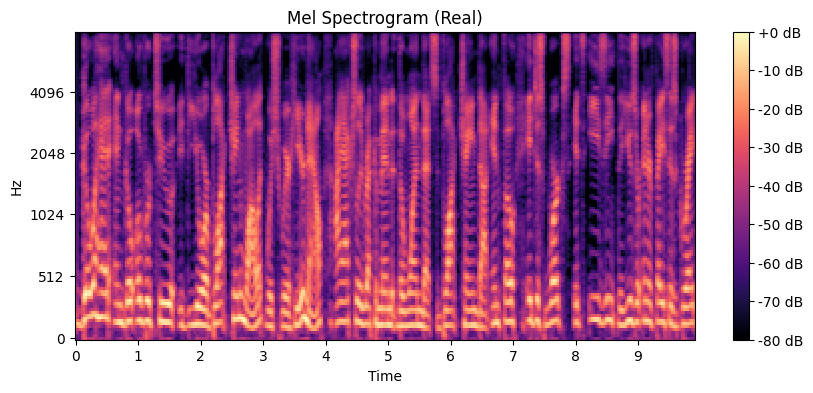

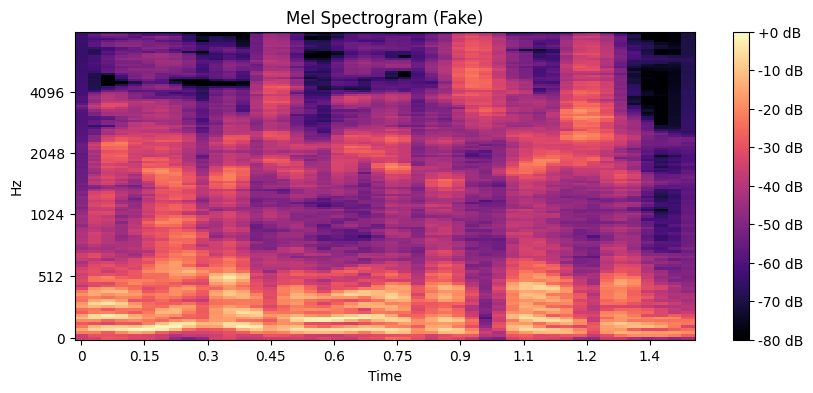

In [70]:
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(file_path, label):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram ({label})")
    plt.show()

# Test with real and fake samples
real_sample = "The Fake-or-Real Dataset /for-norm/for-norm/training/real/file3.wav_16k.wav_norm.wav_mono.wav_silence.wav"
fake_sample = "The Fake-or-Real Dataset /for-norm/for-norm/training/fake/file3.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"

plot_spectrogram(real_sample, "Real")
plot_spectrogram(fake_sample, "Fake")


The Real Mel Spectrogram shows natural, well-distributed spectral energy, harmonics, and smooth transitions.
The Fake Mel Spectrogram is blocky, lacks fine harmonics, and contains discontinuities that suggest artificial synthesis.

### Audio Waveform Analysis (Raw Audio Patterns)

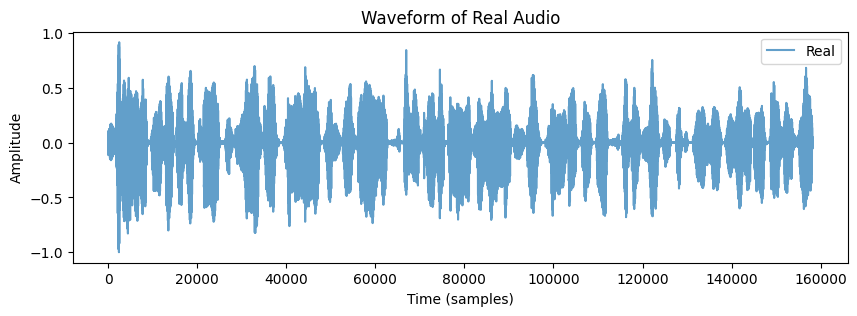

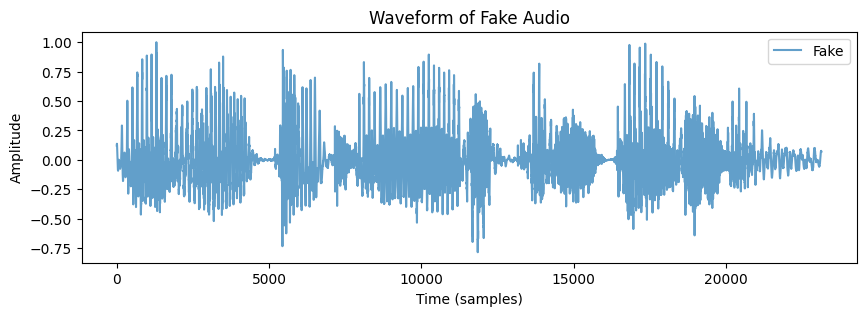

In [71]:
def plot_waveform(file_path, label):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    plt.figure(figsize=(10, 3))
    plt.plot(y, alpha=0.7, label=label)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform of {label} Audio")
    plt.legend()
    plt.show()

plot_waveform(real_sample, "Real")
plot_waveform(fake_sample, "Fake")


Audio Dataset Statistics & Distribution Analysis

/var/folders/cg/tq8ht3997ssbsypggw0jcvvw0000gn/T/ipykernel_20507/4280319629.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Label", y="Duration", data=df, palette="coolwarm")


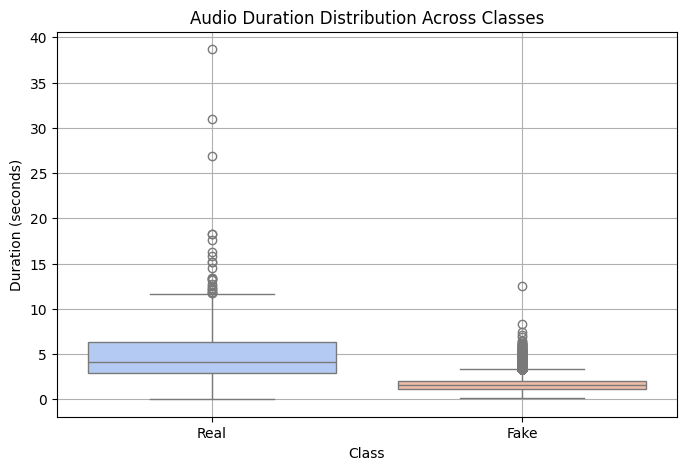

In [74]:
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "The Fake-or-Real Dataset /for-norm/for-norm/training"

# Extract durations and labels
durations = []
labels = []

for label, class_name in enumerate(["real", "fake"]):
    class_path = os.path.join(dataset_path, class_name)
    
    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            duration = len(y) / sr  # Compute duration in seconds
            durations.append(duration)
            labels.append(class_name)
        except:
            continue  # Skip corrupted or unreadable files

# Create DataFrame
df = pd.DataFrame({"Duration": durations, "Label": labels})

# Plot duration distribution using boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Label", y="Duration", data=df, palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=["Real", "Fake"])
plt.title("Audio Duration Distribution Across Classes")
plt.xlabel("Class")
plt.ylabel("Duration (seconds)")
plt.grid()
plt.show()


### Simple CNN

Epoch 1/10:  12%|█▏        | 201/1684 [01:37<11:58,  2.06it/s, loss=0.2]  

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 1/10:  70%|██████▉   | 1171/1684 [09:30<04:07,  2.07it/s, loss=0.0327] 

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 1/10: 100%|██████████| 1684/1684 [13:36<00:00,  2.06it/s, loss=0.0546]  
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


Epoch 1/10 - Train Loss: 0.1727, Train Acc: 94.14%, Val Loss: 0.0588, Val Acc: 97.81%


Epoch 2/10:  44%|████▍     | 739/1684 [06:00<08:06,  1.94it/s, loss=0.0895]  

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 2/10:  62%|██████▏   | 1052/1684 [08:33<05:05,  2.07it/s, loss=0.00808] 

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 2/10: 100%|██████████| 1684/1684 [13:38<00:00,  2.06it/s, loss=0.000509]


Epoch 2/10 - Train Loss: 0.0398, Train Acc: 98.59%, Val Loss: 0.0185, Val Acc: 99.39%


Epoch 3/10:  18%|█▊        | 300/1684 [02:25<11:04,  2.08it/s, loss=0.000212]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 3/10:  27%|██▋       | 456/1684 [03:41<09:46,  2.09it/s, loss=0.0623]  

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 3/10: 100%|██████████| 1684/1684 [13:50<00:00,  2.03it/s, loss=0.0439]  


Epoch 3/10 - Train Loss: 0.0257, Train Acc: 99.14%, Val Loss: 0.0266, Val Acc: 99.03%


Epoch 4/10:  53%|█████▎    | 900/1684 [07:13<06:13,  2.10it/s, loss=0.00248] 

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 4/10:  81%|████████  | 1362/1684 [10:56<02:36,  2.06it/s, loss=0.00749] 

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 4/10: 100%|██████████| 1684/1684 [13:31<00:00,  2.08it/s, loss=0.0098]  


Epoch 4/10 - Train Loss: 0.0214, Train Acc: 99.29%, Val Loss: 0.0238, Val Acc: 99.19%


Epoch 5/10:  62%|██████▏   | 1045/1684 [08:20<05:13,  2.04it/s, loss=0.202]   

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 5/10:  90%|█████████ | 1518/1684 [12:08<01:19,  2.09it/s, loss=0.00966] 

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 5/10: 100%|██████████| 1684/1684 [13:28<00:00,  2.08it/s, loss=0.022]   


Epoch 5/10 - Train Loss: 0.0188, Train Acc: 99.35%, Val Loss: 0.0219, Val Acc: 99.38%


Epoch 6/10:  24%|██▍       | 400/1684 [03:12<10:16,  2.08it/s, loss=0.000636]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 6/10:  84%|████████▍ | 1412/1684 [11:18<02:14,  2.02it/s, loss=0.000301]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 6/10: 100%|██████████| 1684/1684 [13:28<00:00,  2.08it/s, loss=6.57e-6] 


Epoch 6/10 - Train Loss: 0.0108, Train Acc: 99.64%, Val Loss: 0.0101, Val Acc: 99.64%


Epoch 7/10:  64%|██████▎   | 1073/1684 [08:31<04:53,  2.08it/s, loss=0.0035]  

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 7/10:  80%|███████▉  | 1346/1684 [10:41<02:40,  2.11it/s, loss=0.357]   

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 7/10: 100%|██████████| 1684/1684 [13:21<00:00,  2.10it/s, loss=0.000867]


Epoch 7/10 - Train Loss: 0.0166, Train Acc: 99.53%, Val Loss: 0.0265, Val Acc: 99.09%


Epoch 8/10:  38%|███▊      | 635/1684 [05:01<08:22,  2.09it/s, loss=0.0311]  

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 8/10:  64%|██████▎   | 1071/1684 [08:26<04:50,  2.11it/s, loss=1.6e-5]  

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 8/10: 100%|██████████| 1684/1684 [13:15<00:00,  2.12it/s, loss=0.00019] 


Epoch 8/10 - Train Loss: 0.0143, Train Acc: 99.58%, Val Loss: 0.0340, Val Acc: 99.08%


Epoch 9/10:  66%|██████▌   | 1110/1684 [08:41<04:28,  2.14it/s, loss=0.000187]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 9/10:  71%|███████   | 1190/1684 [09:19<03:50,  2.14it/s, loss=1.97e-5] 

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 9/10: 100%|██████████| 1684/1684 [13:11<00:00,  2.13it/s, loss=0]       


Epoch 9/10 - Train Loss: 0.0103, Train Acc: 99.72%, Val Loss: 0.0112, Val Acc: 99.61%


Epoch 10/10:  17%|█▋        | 293/1684 [02:20<11:09,  2.08it/s, loss=1.7e-5]  

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 10/10:  31%|███       | 525/1684 [04:12<09:13,  2.09it/s, loss=0.00316] 

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 10/10: 100%|██████████| 1684/1684 [13:28<00:00,  2.08it/s, loss=5.53e-5] 


Epoch 10/10 - Train Loss: 0.0132, Train Acc: 99.62%, Val Loss: 0.0076, Val Acc: 99.77%


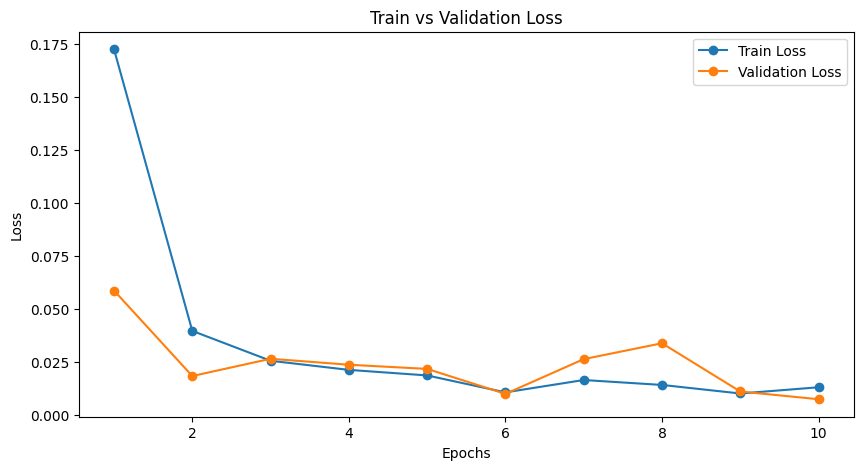

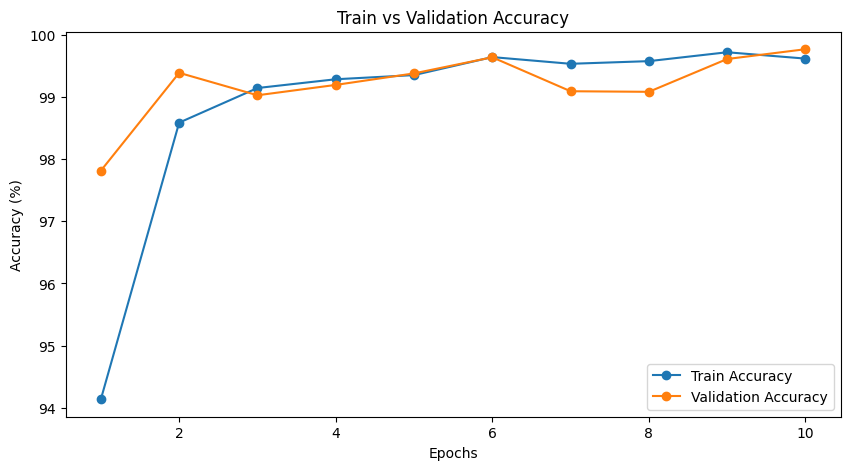

Model saved as audio_cnn.pth


In [35]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Define a simple CNN model
class AudioCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (N_MELS // 8) * (FIXED_LENGTH // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Progress bar
        loop = tqdm(train_loader, leave=True)
        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Plot Train vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.show()

    # Plot Train vs Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker="o")
    plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.show()

# Train the model
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Save the trained model
torch.save(model.state_dict(), "audio_cnn.pth")
print("Model saved as audio_cnn.pth")


### Testing 

Model loaded successfully!


Testing: 100%|██████████| 145/145 [00:35<00:00,  4.10it/s, loss=0.319]   

Test Loss: 13.5382
Accuracy: 0.5602
Precision: 0.5377
Recall: 0.9979
F1 Score: 0.6989


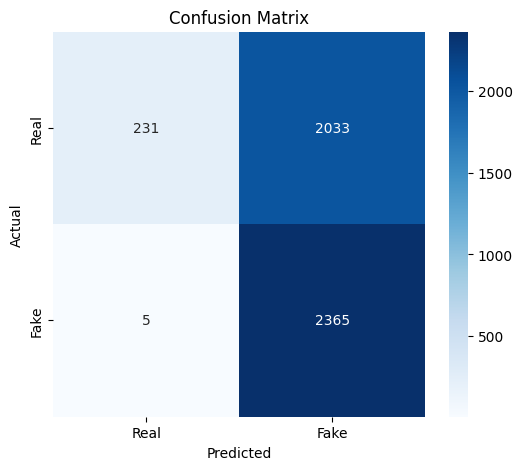

In [58]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from torch.utils.data import DataLoader
from tqdm import tqdm 
import librosa
import os

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same model architecture
class AudioCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 input channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (128 // 8) * (256 // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model
model = AudioCNN().to(device)

# Load model weights, ignoring conv1 if necessary
state_dict = torch.load("audio_cnn.pth", map_location=device)
del state_dict["conv1.weight"]
del state_dict["conv1.bias"]
model.load_state_dict(state_dict, strict=False)

model.eval()  # Set to evaluation mode
print("Model loaded successfully!")

# Load test dataset
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        y, sr = librosa.load(file_path, sr=16000)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure shape (128, 256)
        mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, 256 - mel_spec.shape[1]))), mode="constant")[:, :256]

        # Convert to tensor
        mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # (1, 128, 256)
        mel_spec = torch.cat([mel_spec] * 3, dim=0)  # Convert to 3 channels for CNN

        return mel_spec, torch.tensor(label, dtype=torch.long)

# Load test data
test_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/testing")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate on Test Data with Progress Bar
all_preds, all_labels = [], []
test_loss = 0.0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    loop = tqdm(test_loader, desc="Testing", leave=True)
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1)  # Get predicted labels

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_loss += loss.item()
        loop.set_postfix(loss=loss.item())

# Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
conf_mat = confusion_matrix(all_labels, all_preds)

# Print Metrics
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Using Dropout,Early Stopping and L2 Regularization

Epoch 1/20:   5%|▍         | 76/1684 [00:38<13:40,  1.96it/s]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
Epoch 1/20:  56%|█████▌    | 935/1684 [07:48<06:03,  2.06it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 1/20:  79%|███████▉  | 1330/1684 [11:02<02:53,  2.04it/s]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
Epoch 1/20:  94%|█████████▎| 1577/1684 [13:04<00:52,  2.04it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 1/20: 100%|██████████| 1684/1684 [13:57<00:00,  2.01it/s]
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


Epoch 1 - Train Loss: 0.2488, Train Acc: 91.11%, Val Loss: 0.0657, Val Acc: 97.81%


Epoch 2/20:  84%|████████▎ | 1410/1684 [11:39<02:15,  2.03it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 2/20:  89%|████████▊ | 1494/1684 [12:21<01:34,  2.01it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 2/20: 100%|██████████| 1684/1684 [13:56<00:00,  2.01it/s]


Epoch 2 - Train Loss: 0.0505, Train Acc: 98.25%, Val Loss: 0.0161, Val Acc: 99.44%


Epoch 3/20:  35%|███▍      | 589/1684 [04:55<09:07,  2.00it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 3/20:  37%|███▋      | 619/1684 [05:10<09:08,  1.94it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 3/20: 100%|██████████| 1684/1684 [13:49<00:00,  2.03it/s]


Epoch 3 - Train Loss: 0.0283, Train Acc: 99.04%, Val Loss: 0.0192, Val Acc: 99.45%


Epoch 4/20:  55%|█████▌    | 932/1684 [07:39<06:14,  2.01it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 4/20:  60%|█████▉    | 1003/1684 [08:15<05:40,  2.00it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 4/20: 100%|██████████| 1684/1684 [13:53<00:00,  2.02it/s]


Epoch 4 - Train Loss: 0.0232, Train Acc: 99.22%, Val Loss: 0.0145, Val Acc: 99.53%


Epoch 5/20:   2%|▏         | 26/1684 [00:12<13:53,  1.99it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 5/20:  21%|██        | 355/1684 [02:55<10:47,  2.05it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 5/20: 100%|██████████| 1684/1684 [13:56<00:00,  2.01it/s]


Epoch 5 - Train Loss: 0.0222, Train Acc: 99.30%, Val Loss: 0.0095, Val Acc: 99.68%


Epoch 6/20:  33%|███▎      | 558/1684 [04:35<09:26,  1.99it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 6/20:  94%|█████████▍| 1587/1684 [13:08<00:47,  2.04it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 6/20: 100%|██████████| 1684/1684 [13:56<00:00,  2.01it/s]


Epoch 6 - Train Loss: 0.0172, Train Acc: 99.47%, Val Loss: 0.0062, Val Acc: 99.74%


Epoch 7/20:  66%|██████▌   | 1114/1684 [09:13<04:34,  2.08it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 7/20:  78%|███████▊  | 1318/1684 [10:53<03:03,  2.00it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 7/20: 100%|██████████| 1684/1684 [13:54<00:00,  2.02it/s]


Epoch 7 - Train Loss: 0.0199, Train Acc: 99.43%, Val Loss: 0.0095, Val Acc: 99.68%


Epoch 8/20:  63%|██████▎   | 1066/1684 [08:49<05:00,  2.06it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 8/20:  83%|████████▎ | 1395/1684 [11:31<02:22,  2.03it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 8/20: 100%|██████████| 1684/1684 [13:53<00:00,  2.02it/s]


Epoch 8 - Train Loss: 0.0153, Train Acc: 99.52%, Val Loss: 0.0128, Val Acc: 99.48%


Epoch 9/20:  49%|████▉     | 826/1684 [06:52<07:02,  2.03it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 9/20:  95%|█████████▍| 1596/1684 [13:18<00:43,  2.01it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 9/20: 100%|██████████| 1684/1684 [14:01<00:00,  2.00it/s]


Epoch 9 - Train Loss: 0.0192, Train Acc: 99.44%, Val Loss: 0.0076, Val Acc: 99.73%


Epoch 10/20:  30%|██▉       | 498/1684 [04:08<10:00,  1.97it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 10/20:  49%|████▉     | 833/1684 [06:56<07:02,  2.01it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 10/20: 100%|██████████| 1684/1684 [14:02<00:00,  2.00it/s]


Epoch 10 - Train Loss: 0.0144, Train Acc: 99.58%, Val Loss: 0.0040, Val Acc: 99.93%


Epoch 11/20:  30%|██▉       | 502/1684 [04:10<09:54,  1.99it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 11/20:  53%|█████▎    | 885/1684 [07:20<06:31,  2.04it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 11/20: 100%|██████████| 1684/1684 [13:55<00:00,  2.02it/s]


Epoch 11 - Train Loss: 0.0184, Train Acc: 99.50%, Val Loss: 0.0060, Val Acc: 99.81%


Epoch 12/20:  19%|█▉        | 316/1684 [02:36<11:15,  2.03it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 12/20:  96%|█████████▌| 1617/1684 [13:16<00:32,  2.05it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 12/20: 100%|██████████| 1684/1684 [13:48<00:00,  2.03it/s]


Epoch 12 - Train Loss: 0.0117, Train Acc: 99.62%, Val Loss: 0.0055, Val Acc: 99.81%


Epoch 13/20:   7%|▋         | 114/1684 [00:56<12:48,  2.04it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 13/20:  84%|████████▍ | 1422/1684 [11:33<02:07,  2.06it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 13/20: 100%|██████████| 1684/1684 [13:40<00:00,  2.05it/s]


Epoch 13 - Train Loss: 0.0123, Train Acc: 99.65%, Val Loss: 0.0050, Val Acc: 99.86%


Epoch 14/20:  15%|█▍        | 249/1684 [01:59<11:23,  2.10it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 14/20:  27%|██▋       | 449/1684 [03:37<10:13,  2.01it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 14/20: 100%|██████████| 1684/1684 [13:46<00:00,  2.04it/s]


Epoch 14 - Train Loss: 0.0144, Train Acc: 99.64%, Val Loss: 0.0131, Val Acc: 99.53%


Epoch 15/20:  81%|████████  | 1359/1684 [11:09<02:38,  2.05it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 15/20:  85%|████████▌ | 1438/1684 [11:49<02:09,  1.89it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 15/20: 100%|██████████| 1684/1684 [13:51<00:00,  2.02it/s]


Epoch 15 - Train Loss: 0.0137, Train Acc: 99.61%, Val Loss: 0.0026, Val Acc: 99.90%


Epoch 16/20:  30%|███       | 511/1684 [04:17<09:47,  2.00it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 16/20:  48%|████▊     | 805/1684 [06:44<07:17,  2.01it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 16/20: 100%|██████████| 1684/1684 [14:23<00:00,  1.95it/s]


Epoch 16 - Train Loss: 0.0144, Train Acc: 99.60%, Val Loss: 0.0038, Val Acc: 99.90%


Epoch 17/20:   0%|          | 4/1684 [00:02<15:19,  1.83it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 17/20:  25%|██▍       | 419/1684 [03:40<11:23,  1.85it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 17/20: 100%|██████████| 1684/1684 [14:53<00:00,  1.89it/s]


Epoch 17 - Train Loss: 0.0132, Train Acc: 99.61%, Val Loss: 0.0045, Val Acc: 99.87%


Epoch 18/20:  43%|████▎     | 729/1684 [06:20<08:17,  1.92it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 18/20:  83%|████████▎ | 1405/1684 [12:12<02:29,  1.87it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 18/20: 100%|██████████| 1684/1684 [14:40<00:00,  1.91it/s]


Epoch 18 - Train Loss: 0.0104, Train Acc: 99.69%, Val Loss: 0.0236, Val Acc: 99.31%


Epoch 19/20:   9%|▉         | 158/1684 [01:24<13:21,  1.90it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 19/20:  54%|█████▍    | 906/1684 [08:00<06:54,  1.88it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 19/20: 100%|██████████| 1684/1684 [14:50<00:00,  1.89it/s]


Epoch 19 - Train Loss: 0.0113, Train Acc: 99.67%, Val Loss: 0.0048, Val Acc: 99.86%


Epoch 20/20:  24%|██▎       | 396/1684 [03:27<11:23,  1.88it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 20/20:  76%|███████▌  | 1272/1684 [11:02<03:37,  1.90it/s]

Skipping empty file: The Fake-or-Real Dataset /for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


Epoch 20/20: 100%|██████████| 1684/1684 [14:37<00:00,  1.92it/s]


Epoch 20 - Train Loss: 0.0114, Train Acc: 99.68%, Val Loss: 0.0101, Val Acc: 99.62%
Early stopping triggered.

Final Evaluation:
Precision: 0.9962
Recall: 0.9962
F1 Score: 0.9962

Confusion Matrix:
 [[5393    7]
 [  34 5364]]


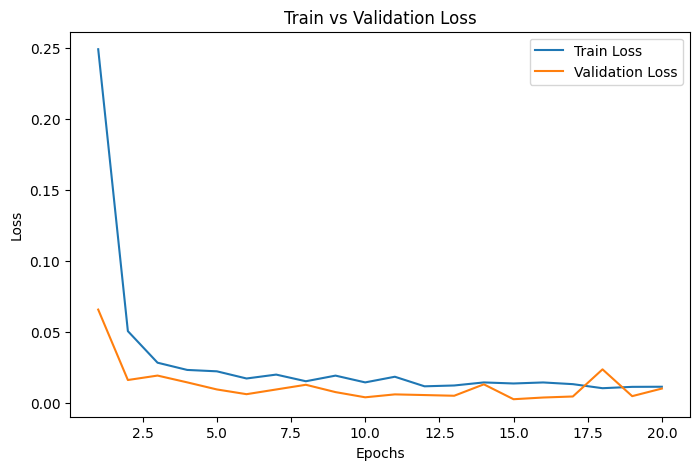

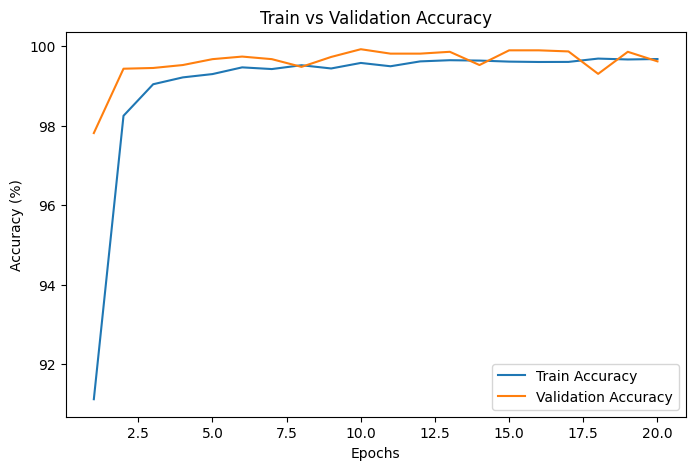

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define Constants
SAMPLE_RATE = 16000  # Ensure consistency
N_MELS = 128
FIXED_LENGTH = 256  # Fixed spectrogram length
BATCH_SIZE = 32  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Audio Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]

        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            if len(y) == 0:
                print(f"Skipping empty file: {file_path}")
                return None

            # Convert to Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Resize spectrogram to fixed shape
            if mel_spectrogram.shape[1] < FIXED_LENGTH:
                pad_width = FIXED_LENGTH - mel_spectrogram.shape[1]
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spectrogram.shape[1] > FIXED_LENGTH:
                mel_spectrogram = mel_spectrogram[:, :FIXED_LENGTH]

            # Convert to PyTorch tensor
            mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
            mel_spectrogram = mel_spectrogram.unsqueeze(0)  # Add channel dimension

            return mel_spectrogram, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

# Custom collate function to handle None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/training")
val_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Define CNN Model with Dropout
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability
        self.fc1 = nn.Linear(128 * (N_MELS // 8) * (FIXED_LENGTH // 8), 256)  
        self.fc2 = nn.Linear(256, 2)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout after convolution layers
        x = x.view(x.size(0), -1)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc2(x)
        return x

# Initialize Model, Loss, Optimizer with L2 Regularization
model = AudioCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization

# Training with Early Stopping
num_epochs = 20
best_val_loss = float("inf")
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final Evaluation Metrics
print("\nFinal Evaluation:")
print(f"Precision: {precision_score(val_labels, val_preds, average='macro'):.4f}")
print(f"Recall: {recall_score(val_labels, val_preds, average='macro'):.4f}")
print(f"F1 Score: {f1_score(val_labels, val_preds, average='macro'):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(val_labels, val_preds))

# Plot Train vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()

# Plot Train vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Train vs Validation Accuracy")
plt.show()



### Testing

Testing: 100%|██████████| 145/145 [00:29<00:00,  4.93it/s, loss=4]      



Test Loss: 1.7425
Accuracy: 0.6204
Precision: 1.0000
Recall: 0.2578
F1 Score: 0.4099


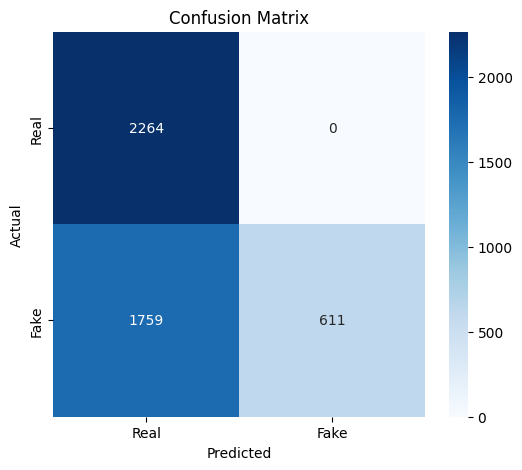

In [59]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader
import librosa
import os

# Define Constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Dataset for Testing
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            if len(y) == 0:
                print(f"Skipping empty file: {file_path}")
                return None

            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            if mel_spec.shape[1] < FIXED_LENGTH:
                pad_width = FIXED_LENGTH - mel_spec.shape[1]
                mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spec.shape[1] > FIXED_LENGTH:
                mel_spec = mel_spec[:, :FIXED_LENGTH]

            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

            return mel_spec, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

# Custom collate function to handle None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load test dataset
test_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/testing")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Define Model (Same as in Training)
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * (N_MELS // 8) * (FIXED_LENGTH // 8), 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the trained model
model = AudioCNN().to(DEVICE)
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()

# Test Loop with Progress Bar
all_preds, all_labels = [], []
test_loss = 0.0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    loop = tqdm(test_loader, desc="Testing", leave=True)
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_loss += loss.item()
        loop.set_postfix(loss=loss.item())

# Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="binary")
recall = recall_score(all_labels, all_preds, average="binary")
f1 = f1_score(all_labels, all_preds, average="binary")
conf_mat = confusion_matrix(all_labels, all_preds)

# Print Metrics
print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### CRNN

Epoch 1/20 [Training]:  18%|█▊        | 296/1684 [02:04<09:25,  2.45it/s, loss=0.249]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
Epoch 1/20 [Training]:  66%|██████▌   | 1111/1684 [07:48<03:57,  2.42it/s, loss=0.625]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Epoch 1/20 [Training]:  68%|██████▊   | 1145/1684 [08:02<03:46,  2.38it/s, loss=0.663]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
Epoch 1/20 [Validation]:  38%|███▊      | 127/338 [00:26<00:44,  4.73it/s, loss=0.278]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is

Epoch 1/20 - Train Loss: 0.3559, Train Acc: 84.64%, Val Loss: 0.3810, Val Acc: 83.66%


Epoch 2/20 [Validation]: 100%|██████████| 338/338 [01:07<00:00,  5.03it/s, loss=0.432]


Epoch 2/20 - Train Loss: 0.3554, Train Acc: 84.75%, Val Loss: 0.3667, Val Acc: 84.02%


Epoch 3/20 [Validation]: 100%|██████████| 338/338 [01:05<00:00,  5.15it/s, loss=0.352]


Epoch 3/20 - Train Loss: 0.3533, Train Acc: 84.87%, Val Loss: 0.3589, Val Acc: 83.97%


Epoch 4/20 [Validation]: 100%|██████████| 338/338 [01:06<00:00,  5.09it/s, loss=0.533]


Epoch 4/20 - Train Loss: 0.3522, Train Acc: 84.95%, Val Loss: 0.3642, Val Acc: 84.65%


Epoch 5/20 [Validation]: 100%|██████████| 338/338 [01:04<00:00,  5.21it/s, loss=0.418]


Epoch 5/20 - Train Loss: 0.3521, Train Acc: 85.03%, Val Loss: 0.3563, Val Acc: 84.94%


Epoch 6/20 [Validation]: 100%|██████████| 338/338 [01:04<00:00,  5.26it/s, loss=0.543]


Epoch 6/20 - Train Loss: 0.3509, Train Acc: 84.96%, Val Loss: 0.3704, Val Acc: 84.85%


Epoch 7/20 [Validation]: 100%|██████████| 338/338 [01:08<00:00,  4.95it/s, loss=0.464]


Epoch 7/20 - Train Loss: 0.3526, Train Acc: 84.80%, Val Loss: 0.3572, Val Acc: 84.46%


Epoch 8/20 [Validation]: 100%|██████████| 338/338 [01:05<00:00,  5.18it/s, loss=0.493]


Epoch 8/20 - Train Loss: 0.3553, Train Acc: 84.86%, Val Loss: 0.3680, Val Acc: 83.48%


Epoch 9/20 [Validation]: 100%|██████████| 338/338 [01:04<00:00,  5.22it/s, loss=0.351]


Epoch 9/20 - Train Loss: 0.3530, Train Acc: 84.89%, Val Loss: 0.3727, Val Acc: 84.08%


Epoch 10/20 [Validation]: 100%|██████████| 338/338 [01:06<00:00,  5.08it/s, loss=0.372]

Epoch 10/20 - Train Loss: 0.3507, Train Acc: 85.01%, Val Loss: 0.3594, Val Acc: 84.85%
Early stopping triggered.
Precision: 0.8235, Recall: 0.8870, F1-Score: 0.8541


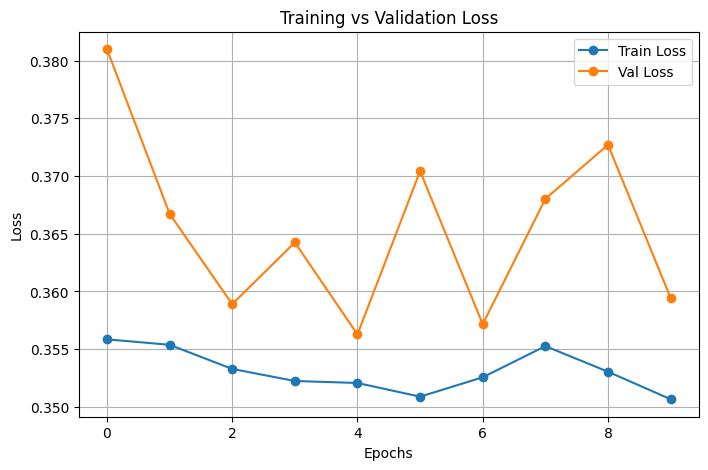

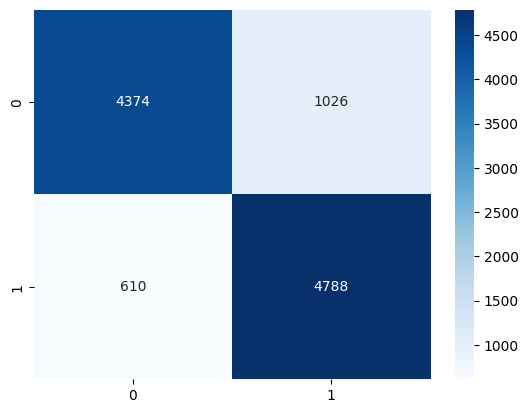

In [ ]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 20
PATIENCE = 5  # Early stopping patience

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Ensure the spectrogram has a fixed shape (128, 256)
            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]

            # Convert to PyTorch tensor and add a channel dimension
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 256)

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/training")
val_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# CRNN Model with Dropout & L2 Regularization
class CRNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CRNN, self).__init__()
        
        # Convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # (batch, 32, 64, 128)
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # (batch, 64, 32, 64)
            nn.Dropout(0.3)
        )

        # LSTM layer
        self.lstm = nn.LSTM(input_size=64 * 64,  # Corrected: 4096
                            hidden_size=128, num_layers=2, 
                            batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        x = self.conv(x)  # (batch, 64, 32, 64)
        x = x.permute(0, 2, 3, 1)  # (batch, time_steps=32, width=64, channels=64)
        x = x.reshape(x.shape[0], x.shape[1], -1)  # (batch, time_steps=32, features=64*64=4096)
        x, _ = self.lstm(x)  # Now correctly passes into LSTM
        x = self.fc(x[:, -1, :])  # Take last time-step output
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training with Early Stopping
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")  # Progress bar
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")  # Progress bar
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Performance Metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.show()


In [47]:
torch.save(model.state_dict(), "crnn_best.pth")


Testing

Testing Model: 100%|██████████| 145/145 [00:26<00:00,  5.57it/s]

Accuracy: 0.3770
Precision: 0.4302
Recall: 0.6717
F1-Score: 0.5245


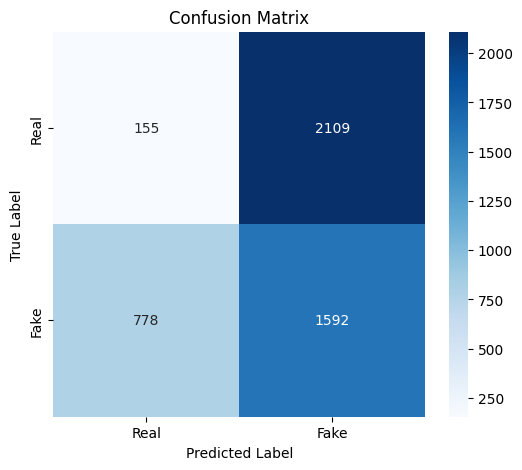

In [67]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load best model
model.load_state_dict(torch.load("best_model.pth"), strict=False)
model.to(device)
model.eval()

# Initialize lists to store predictions and true labels
all_preds, all_labels = [], []

# Test DataLoader
test_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/testing")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Test Progress Bar
test_bar = tqdm(test_loader, desc="Testing Model")

with torch.no_grad():
    for inputs, labels in test_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Performance Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### ResNet50

Epoch 1/10 [Training]:  40%|███▉      | 673/1684 [31:30<47:43,  2.83s/it, loss=0.00448]   /opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
Epoch 1/10 [Training]:  51%|█████▏    | 866/1684 [40:32<39:47,  2.92s/it, loss=0.0516]  /opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Epoch 1/10 [Training]:  60%|█████▉    | 1003/1684 [1:06:20<31:47,  2.80s/it, loss=0.00158]    /opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
Epoch 1/10 [Validation]:  38%|███▊      | 127/338 [03:33<05:52,  1.67s/it, loss=0.000105]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarn

Epoch 1/10 - Train Loss: 0.0337, Train Acc: 98.79%, Val Loss: 0.0030, Val Acc: 99.93%
Model saved successfully as resnet50_best.pth


Epoch 2/10 [Validation]: 100%|██████████| 338/338 [09:59<00:00,  1.77s/it, loss=0.0105]  


Epoch 2/10 - Train Loss: 0.0100, Train Acc: 99.66%, Val Loss: 0.0087, Val Acc: 99.68%


Epoch 3/10 [Validation]: 100%|██████████| 338/338 [10:07<00:00,  1.80s/it, loss=0.000128]


Epoch 3/10 - Train Loss: 0.0063, Train Acc: 99.79%, Val Loss: 0.0022, Val Acc: 99.94%
Model saved successfully as resnet50_best.pth


Epoch 4/10 [Validation]: 100%|██████████| 338/338 [09:28<00:00,  1.68s/it, loss=0.00201] 


Epoch 4/10 - Train Loss: 0.0076, Train Acc: 99.77%, Val Loss: 0.0378, Val Acc: 98.85%


Epoch 5/10 [Validation]: 100%|██████████| 338/338 [1:38:11<00:00, 17.43s/it, loss=0.000566]    


Epoch 5/10 - Train Loss: 0.0050, Train Acc: 99.85%, Val Loss: 0.0030, Val Acc: 99.91%


Epoch 6/10 [Validation]: 100%|██████████| 338/338 [10:14<00:00,  1.82s/it, loss=0.000384]


Epoch 6/10 - Train Loss: 0.0061, Train Acc: 99.81%, Val Loss: 0.0026, Val Acc: 99.93%


Epoch 7/10 [Validation]: 100%|██████████| 338/338 [49:29<00:00,  8.78s/it, loss=0.00405]    


Epoch 7/10 - Train Loss: 0.0046, Train Acc: 99.86%, Val Loss: 0.0018, Val Acc: 99.94%
Model saved successfully as resnet50_best.pth


Epoch 8/10 [Validation]: 100%|██████████| 338/338 [10:06<00:00,  1.80s/it, loss=0.00861] 


Epoch 8/10 - Train Loss: 0.0037, Train Acc: 99.90%, Val Loss: 0.0062, Val Acc: 99.83%


Epoch 9/10 [Validation]: 100%|██████████| 338/338 [09:50<00:00,  1.75s/it, loss=0.00257] 


Epoch 9/10 - Train Loss: 0.0040, Train Acc: 99.89%, Val Loss: 0.0016, Val Acc: 99.97%
Model saved successfully as resnet50_best.pth


Epoch 10/10 [Validation]: 100%|██████████| 338/338 [09:30<00:00,  1.69s/it, loss=0.0115]  

Epoch 10/10 - Train Loss: 0.0030, Train Acc: 99.93%, Val Loss: 0.0044, Val Acc: 99.86%

=== Performance Metrics ===
Precision: 0.9986
Recall:    0.9986
F1 Score:  0.9986


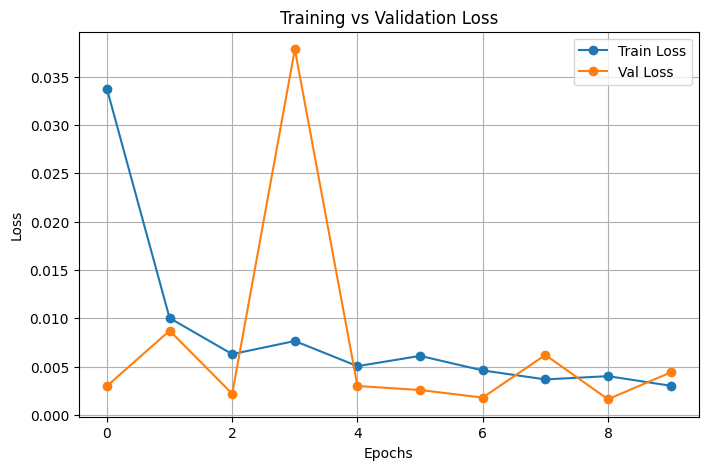

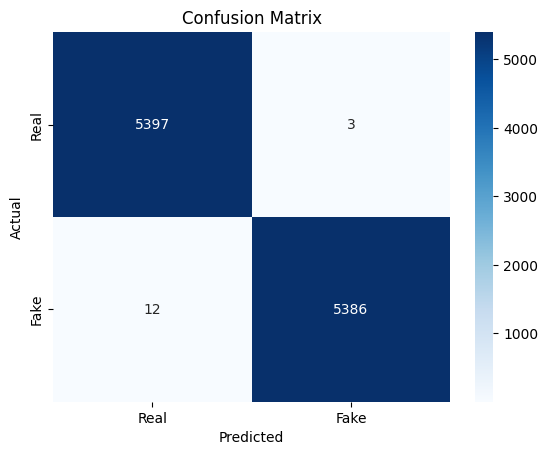

In [50]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 5  # Early stopping patience

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Ensure the spectrogram has a fixed shape (128, 256)
            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]

            # Normalize and convert to tensor
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 256)
            mel_spec = torch.cat([mel_spec] * 3, dim=0)  # Convert to 3 channels for ResNet

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/training")
val_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Load Pretrained ResNet50 and Modify
class PretrainedResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedResNet, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PretrainedResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training with Early Stopping
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")  # Progress bar
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]")  # Progress bar
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # Save the best model
        torch.save(model.state_dict(), "resnet50_best.pth")
        print("Model saved successfully as resnet50_best.pth")

    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

# Compute Precision, Recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

# Print Metrics
print("\n=== Performance Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid()
plt.show()

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Testing

/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing Model: 100%|██████████| 145/145 [04:03<00:00,  1.68s/it]


=== Performance Metrics ===
Accuracy:  0.5227
Precision: 1.0000
Recall:    0.0667
F1 Score:  0.1250


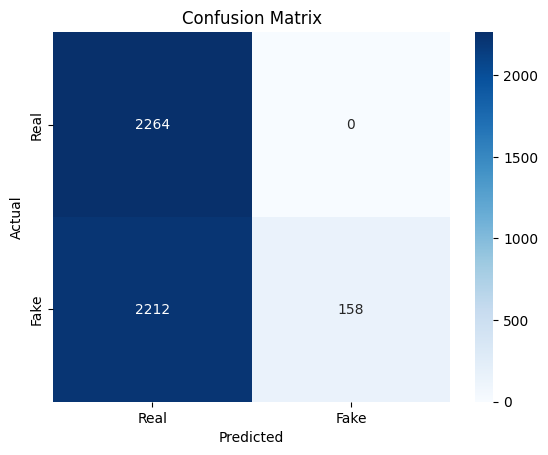

In [68]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader

# Define constants
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_LENGTH = 256
BATCH_SIZE = 32

# Custom Dataset for Testing
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Ensure the spectrogram has a fixed shape (128, 256)
            mel_spec = np.pad(mel_spec, ((0, 0), (0, max(0, FIXED_LENGTH - mel_spec.shape[1]))), mode="constant")[:, :FIXED_LENGTH]

            # Normalize and convert to tensor
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 128, 256)
            mel_spec = torch.cat([mel_spec] * 3, dim=0)  # Convert to 3 channels for ResNet

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except:
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load test dataset
test_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/testing")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Load Pretrained ResNet50 Model
class PretrainedResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedResNet, self).__init__()
        self.model = models.resnet50(pretrained=False)  # pretrained=False since we are loading saved weights
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PretrainedResNet().to(device)
model.load_state_dict(torch.load("resnet50_best.pth"))
model.eval()

# Testing Loop
test_preds, test_labels = [], []
test_bar = tqdm(test_loader, desc="Testing Model")

with torch.no_grad():
    for inputs, labels in test_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Compute Metrics
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average="binary")

print("\n=== Performance Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
conf_mat = confusion_matrix(test_labels, test_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Loading ResNet101 and Modifying the preprocessing code to allow for 3-channel RGB images in case of 1-channel (grayscale) Mel spectrograms

In [36]:
import os
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn

# Define constants
SAMPLE_RATE = 16000
N_MELS = 1287
FIXED_LENGTH = 256
BATCH_SIZE = 32

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.classes = ["real", "fake"]

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            if len(y) == 0:
                print(f"Skipping empty file: {file_path}")
                return None

            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Resize spectrogram to fixed shape
            if mel_spec.shape[1] < FIXED_LENGTH:
                pad_width = FIXED_LENGTH - mel_spec.shape[1]
                mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spec.shape[1] > FIXED_LENGTH:
                mel_spec = mel_spec[:, :FIXED_LENGTH]

            # Convert to PyTorch tensor
            mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
            mel_spec = mel_spec.unsqueeze(0)  # (1, 1287, 256)
            mel_spec = mel_spec.expand(3, -1, -1)  # Convert to (3, 1287, 256) for ResNet

            return mel_spec, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# Load dataset
train_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/training")
val_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/validation")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Define ResNet101 Model
class PretrainedResNet101(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedResNet101, self).__init__()
        self.model = models.resnet101(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PretrainedResNet101().to(device)

print("Model and Data Loaded Successfully!")


/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/kartl/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:05<00:00, 34.2MB/s] 


Model and Data Loaded Successfully!


### Evaluating ResNet101

Evaluating Model:  38%|███▊      | 127/338 [45:46<1:16:43, 21.82s/it]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(
Evaluating Model: 100%|██████████| 338/338 [2:01:57<00:00, 21.65s/it]  


=== Performance Metrics ===
Accuracy:  0.5001
Precision: 0.2501
Recall:    0.5001
F1 Score:  0.3334



/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


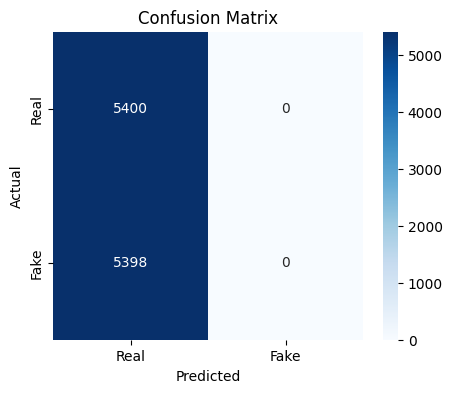

In [39]:
from tqdm import tqdm  # Import tqdm for progress tracking

# Ensure model is in evaluation mode
model.eval()

# Lists to store predictions and labels
all_preds, all_labels = [], []

# Wrap the validation loader with tqdm for a progress bar
with torch.no_grad():
    val_bar = tqdm(val_loader, desc="Evaluating Model", leave=True)
    
    for inputs, labels in val_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        preds = outputs.argmax(dim=1)  # Get predicted class

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute performance metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

# Print Metrics
print("\n=== Performance Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### ResNet101

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchvision import models
from tqdm import tqdm

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNet101Audio(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet101Audio, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # Modify first convolution layer for 1-channel input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 2)  # Binary classification (real vs fake)
        )

    def forward(self, x):
        return self.model(x)

model = ResNet101Audio().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 Regularization

# Early Stopping Variables
best_val_loss = float("inf")
patience_counter = 0
PATIENCE = 5
EPOCHS = 100
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "resnet101.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

y_true, y_pred = [], []
model.load_state_dict(torch.load("resnet101.pth"))
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


  0%|          | 0/1684 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Epoch [1/100]:   0%|          | 1/1684 [00:52<24:25:53, 52.26s/it, loss=0.692]

### VGG16

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the preprocessed dataset
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# === Define VGG16 Model ===
class VGG16Model(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16Model, self).__init__()
        self.model = models.vgg16(pretrained=True)
        
        # Modify the classifier
        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Initialize Model
model = VGG16Model().to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 Regularization

# Early Stopping Parameters
patience = 5
best_val_loss = float("inf")
counter = 0

# === Training Function ===
def train_model(model, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation Phase
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute Metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
        rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
        f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

        # Early Stopping
        global best_val_loss, counter
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_vgg16_model.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot Training & Validation Loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

# Train the Model
train_model(model, train_loader, val_loader, epochs=20)

# === Load the Best Model ===
model.load_state_dict(torch.load("best_vgg16_model.pth"))
model.to(device)
model.eval()

# === Evaluate on Validation Set ===
def evaluate_model(model, val_loader):
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    print("\n=== Performance Metrics ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate Model
evaluate_model(model, val_loader)


/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/envs/myenv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 1, 1287, 256] to have 3 channels, but got 1 channels instead

### Wave2Vec 2.0

In [2]:
import os
import torch
import torchaudio
import librosa
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "facebook/wav2vec2-large-xlsr-53"
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

class AudioDataset(Dataset):
    def __init__(self, root_dir, processor, target_length=5):
        self.processor = processor
        self.data, self.labels = [], []
        self.classes = ["real", "fake"]
        self.sr = 16000  # Sampling rate
        self.target_length = target_length * self.sr  # Fixed length in samples

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                self.data.append(os.path.join(class_path, file))
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        waveform, _ = librosa.load(file_path, sr=self.sr)

        # 🔹 Ensure all audio inputs are of fixed length
        if len(waveform) > self.target_length:
            waveform = waveform[:self.target_length]  # Truncate
        else:
            pad_length = self.target_length - len(waveform)
            waveform = np.pad(waveform, (0, pad_length), mode="constant")  # Pad

        inputs = self.processor(waveform, sampling_rate=self.sr, return_tensors="pt", padding=True)
        return inputs.input_values.squeeze(0), torch.tensor(label, dtype=torch.long)

train_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/training", processor)
val_dataset = AudioDataset("The Fake-or-Real Dataset /for-norm/for-norm/validation", processor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

num_epochs = 100
train_losses, val_losses = [], []
best_val_loss = float("inf")
early_stop_patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  
    
    for batch in progress_bar:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})  
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss, correct = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()



Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/100:   0%|          | 0/3367 [00:02<?, ?it/s]


KeyboardInterrupt: 

### Load & Evaluate ResNet-101

Evaluating: 100%|██████████| 675/675 [33:55<00:00,  3.01s/it]



Validation Accuracy: 0.4963
Precision: 0.4981
Recall: 0.9898
F1 Score: 0.6627


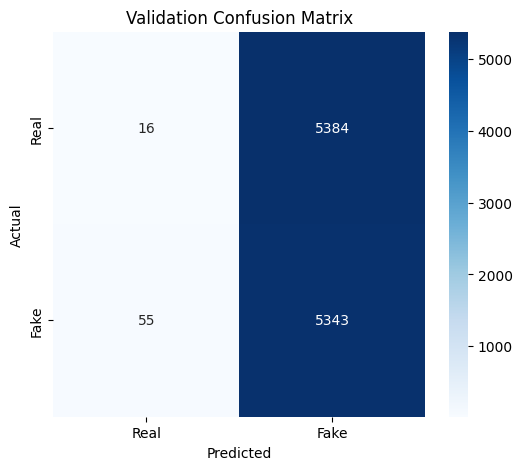

In [20]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm

# 🔹 Set Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Custom Dataset for Audio (Convert to Mel Spectrograms)
class AudioDataset(Dataset):
    def __init__(self, root_dir, target_sample_rate=16000, num_mel_bins=128):
        self.root_dir = root_dir
        self.files, self.labels = [], []
        self.classes = ["real", "fake"]  # Labels: 0 (real), 1 (fake)
        self.sr = target_sample_rate
        self.mel_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=num_mel_bins)

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                self.files.append(os.path.join(class_path, file))
                self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx], self.labels[idx]
        waveform, sr = torchaudio.load(file_path)

        # 🔹 Resample if needed
        if sr != self.sr:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sr)
            waveform = resampler(waveform)

        # 🔹 Convert to Mel Spectrogram (1-channel image)
        mel_spec = self.mel_transform(waveform).squeeze(0)  # Shape: (128, Time)
        return mel_spec, torch.tensor(label, dtype=torch.long)

# 🔹 Custom Collate Function for Padding
def pad_collate(batch):
    spectrograms, labels = zip(*batch)

    # 🔹 Find maximum time dimension
    max_time = max(spec.shape[1] for spec in spectrograms)

    # 🔹 Pad all spectrograms to the same length
    padded_spectrograms = []
    for spec in spectrograms:
        pad_size = max_time - spec.shape[1]
        padded_spec = torch.nn.functional.pad(spec, (0, pad_size))  # Pad on the right
        padded_spectrograms.append(padded_spec)

    # 🔹 Stack & Add a Channel Dimension for ResNet: (batch_size, 1, freq_bins, time_steps)
    return torch.stack(padded_spectrograms).unsqueeze(1), torch.tensor(labels)

# 🔹 Load the Validation Dataset with Collate Function
val_dataset_path = "The Fake-or-Real Dataset /for-norm/for-norm/validation"
val_dataset = AudioDataset(val_dataset_path)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate)

# 🔹 Define ResNet-101 Model for Audio Classification
class ResNet101Audio(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet101Audio, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # 🔹 Modify first convolution layer for 1-channel input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # 🔹 Modify final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 2)  # Binary classification (real vs fake)
        )

    def forward(self, x):
        return self.model(x)

# 🔹 Load the Trained Model
model = ResNet101Audio().to(device)
model.load_state_dict(torch.load("ResNet_101.pth", map_location=device))
model.eval()

# 🔹 Evaluate Model on Validation Set
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating", leave=True):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 🔹 Compute Performance Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="binary")
recall = recall_score(y_true, y_pred, average="binary")
f1 = f1_score(y_true, y_pred, average="binary")

print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 🔹 Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()
